# Crypto Analysis: Principal Component Analysis

In this notebook, we apply principal component analysis on a cryptocurrency dataset. The file ```cryptocurrency_prices.txt``` contains the daily price time series of the following seven cryptocurrencies (in this order): 

- Bitcoin, 
- Dash, 
- Ethereum, 
- Litecoin, 
- Monero, 
- Nem, 
- Ripple. 

There are 929 daily prices and the time series ends in February 2018.


## Principal component analysis

Principal component analysis (PCA) is a dimensionality reduction technique used to map a set of correlated variables onto a new set of uncorrelated variables called principal components. Principal components can be ranked in order of importance based on the fraction of the variance of the original data that they can explain.

Consider $N$ time series of length $T$ with a correlation matrix $C$. The standardized return for stock $i$ at time $t$ is $x_{i,t}$. The eigenvalue problem is given by

\begin{equation}
    C v_i = \lambda_i v_i, \,\,\, i=1,2,...,N
\end{equation}

where $\lambda_i \geq 0$ denotes the eigenvalue and $v_i = [v_{i,1}, ..., v_{i,N}]^T$ is a normalized eigenvector such that

\begin{equation}
    \sum_{k=1}^N v_{i,k}^2 = 1.
\end{equation}

A principal component (PC) is given by

\begin{equation}
    e_{i,t} = \frac{1}{\lambda_i} \sum_{k=1}^N v_{i,k}x_{k,t}.
\end{equation}

PCs have zero mean, unit standard deviation and are exactly uncorrelated, i.e.,

\begin{equation}
    \frac{1}{T} \sum_{t=1}^T e_{i,t} e_{j,t} = 0.
\end{equation}

The relationship with our original variable is

\begin{equation}
    x_{i,t} = \sum_{k=1}^N \sqrt{\lambda_k} v_{i,k} e_{k,t}.
\end{equation}

By design, the trace of a correlation matrix is $N$ (only ones on the diagonal), and it is also equal to the sum of the eigenvalues, i.e.,

\begin{equation}
    \sum_{k=1}^N \lambda_k = N.
\end{equation}

Also, by design, $e_{k,t}$ and $v_{i, k}$ are roughly of order one ($e$ have zero mean and unit standard deviation and $v$ is normalized). Therefore, whenever a few eigenvalues dominate, we can approximate the original variable with a few PCs and use them to get intuition, i.e.,

\begin{equation}
    x_{i,t} \approx \sum_{k=1}^{M<N} \sqrt{\lambda_k} v_{i,k} e_{k,t}.
\end{equation}

The presence of large eigenvalues means that the corresponding PCs account for a large fraction of the overall variance in the data because

\begin{equation}
    1 = \text{Var}(x_{i,t}) = \sum_{k=1}^N \lambda_k v_{i,k}^2.
\end{equation}

## Crypto analysis

First, let's import the libraries and the files, compute standardized returns and the correlation matrix.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('cryptocurrency_prices.txt', header=None)

for i in range(data.shape[0]):
    temp = data.iloc[i,0].split('	')
    temp = np.array(list(filter(None, temp))).astype('float')    
    if i == 0:
        prices = temp
    else:
        prices = np.vstack((prices, temp))

# Building log returns
R = np.empty((0, prices.shape[1]-1))

for i in range(len(prices)):
    R = np.vstack((R, np.diff(np.log(prices[i,:]))))

# Store number of rows and columns
N = R.shape[0] # Number of variables
T = R.shape[1] # Depth of the time series

# Standardize data
X = np.empty((0, R.shape[1]))

for i in range(N):
    X = np.vstack((X, (R[i, :] - np.mean(R[i, :]))/np.std(R[i, :], ddof=1)))

# Correlation matrix        
C = np.corrcoef(R)

### Correlation significance

Now we want to test the statistical significance of the correlations. To do so, we are going to perform a random permutation test. This involves repeatedly computing the correlation coefficient on two time series after randomly shuffling their values. From those values, we get a confidence interval and analyze if our actual correlation coefficient falls inside the confidence interval. If the correlation coefficient is outside of the interval, it can be considered statistically significant. Randomly shuffling the returns breaks the time correlation. However, there may be residual correlation due to the distributional properties of the data. Here we are going to do the inspection visually by constructing the interval with a box plot showing the distribution of the correlation coefficients over 500 permutations.

We have seven cryptocurrencies so there are $N(N-1)/2$ pairwise correlation coefficients. 

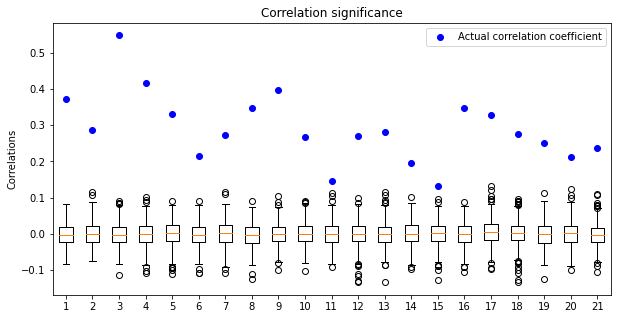

In [8]:
Nsamples = 500 # Number of times correlation between reshuffled returns is computed
c = 1
x = np.empty((Nsamples, 0))
coeff = np.empty((0, 1))

for i in range(N):
    for j in range(i+1, N):
        aux = np.empty((0, 1))
        for ns in range(Nsamples):
            # Compute correlation on randomly reshuffled returns
            aux = np.vstack((aux, np.sum(X[i, np.random.permutation(T)]*X[j, np.random.permutation(T)])/T))

        x = np.column_stack((x, aux))      
        coeff = np.vstack((coeff, C[i, j]))
        c += 1

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.boxplot(x)
ax.plot(np.linspace(1,int(N*(N-1)/2),int(N*(N-1)/2)), coeff, 'bo', label='Actual correlation coefficient')
ax.set_ylabel('Correlations')
ax.set_title('Correlation significance')
ax.legend(loc='best');

From the plot above, we see that all our correlation coefficients fall outside of the intervals and are even above the outliers. Therefore, our correlation coefficients are statistically significant (w.r.t the permutation test).

### PCA

Now, let's compute the eigenvalues and eigenvectors and build the principal components. 

In [11]:
# Compute eigenvalues and eigenvectors
eig_value, eig_vector = np.linalg.eig(C) 

# Sort eigenvalues from largest to smallest and corresponding eigenvector
idx = eig_value.argsort()[::-1]   
eig_value = eig_value[idx]
eig_vector = eig_vector[:,idx]

# Print eigenvalues and percentage of variance explained by each
for i in range(N):
    print('eigenvalue ' + str(i+1) + ' = ' + str(round(eig_value[i],3)) \
          + '  (' + str(round(eig_value[i]/N*100,2)) + ' percent of variance explained)')

# Print the first components of the eigenvectors
print('\n')
for i in range(N):
    print('Component ' + str(i+1) + ' of 1st eigenvector = ' + str(round(eig_vector[i, 0], 2)) \
          + '; Component ' + str(i+1) + ' of 2nd eigenvector = ' + str(round(eig_vector[i, 1], 2)))

# Building principal components
E = np.empty((0, R.shape[1]))

for i in range(N):
    E = np.vstack((E, np.sum(eig_vector[:, i][:,None] * X, axis=0)/np.sqrt(eig_value[i])))

eigenvalue 1 = 2.806  (40.09 percent of variance explained)
eigenvalue 2 = 0.933  (13.33 percent of variance explained)
eigenvalue 3 = 0.783  (11.18 percent of variance explained)
eigenvalue 4 = 0.741  (10.58 percent of variance explained)
eigenvalue 5 = 0.704  (10.05 percent of variance explained)
eigenvalue 6 = 0.596  (8.52 percent of variance explained)
eigenvalue 7 = 0.438  (6.25 percent of variance explained)


Component 1 of 1st eigenvector = -0.45; Component 1 of 2nd eigenvector = 0.05
Component 2 of 1st eigenvector = -0.39; Component 2 of 2nd eigenvector = 0.33
Component 3 of 1st eigenvector = -0.32; Component 3 of 2nd eigenvector = 0.39
Component 4 of 1st eigenvector = -0.44; Component 4 of 2nd eigenvector = -0.1
Component 5 of 1st eigenvector = -0.4; Component 5 of 2nd eigenvector = 0.21
Component 6 of 1st eigenvector = -0.34; Component 6 of 2nd eigenvector = -0.32
Component 7 of 1st eigenvector = -0.27; Component 7 of 2nd eigenvector = -0.76


The principal component associated to the first eigenvalue explains 40\% of the variability in the data. 

The components of the first eigenvector share the same sign and are more or less of the same size. This eigenvector tells us that the interpretation of our first principal component is that of a market mode. It represents the collective movement of the market on any given day. 

The components of the second eigenvector do not share the same sign and are not of the same magnitude. All the cryptocurrencies are not affected by this component in the same way. While the first mode is a source of positive correlation, the second one is a source of negative correlation between two groups of cryptocurrencies.

## Trading strategy

Let's compare two trading strategies. For the first one, we construct a portfolio with all the principal components. For the second one, we remove the first principal component. We repeatedly construct portfolios with a training period of 100 days and an out-of-sample period of 50 days. The portfolios are constructed based on Markowitz's optimal portfolio theory. The goal is to find the weights that minimize portfolio variance with a budget constraint, i.e.,

\begin{equation}
    \sum_{i=1}^N w_i = 1
\end{equation}

where $w_i$ is the weight of asset $i$. There are $N$ assets and short-selling is allowed. The optimal weights are given by

\begin{equation}
    w_i^* = \frac{\sum_{j=1}^N (C^{-1})_{i,j}}{\sum_{j,k=1}^N (C^{-1})_{j,k}}.
\end{equation}

Finally, we compare the in-sample and out-of-sample Sharpe ratios of the two strategies.

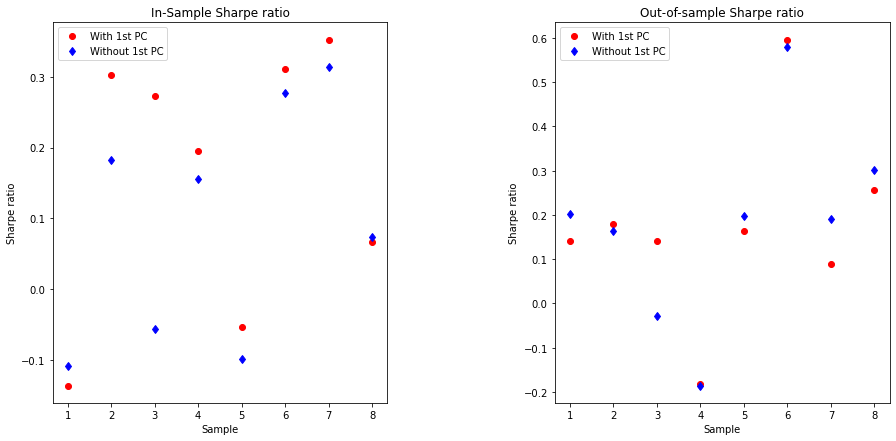

In [17]:
T_in = 100
T_out = 50

Sharpe = np.empty((0, 4)) # Array to store the sharpe ratios in/out of sample and with/without principal component

for t in range(0, 800, T_in):
    
    # Full portfolio with all principal components
    
    X = np.empty((0, T_in))
    for i in range(N):
        X = np.vstack((X, (R[i, t:t+T_in] - np.mean(R[i, t:t+T_in]))/np.std(R[i, t:t+T_in], ddof=1)))

    C = np.corrcoef(X) # In-sample correlation matrix
    I = np.linalg.inv(C) # Inverse of in-sample correlation matrix
    
    P1_in = np.empty((0, T_in))
    P1_out = np.empty((0, T_out))
    
    for i in range(N):
        w = np.sum(I[i,:])/np.sum(I) # Portfolio weight for ith crypto
        P1_in = np.vstack((P1_in, w*R[i, t:t+T_in])) # In-sample weighted return of ith crypto
        P1_out = np.vstack((P1_out, w*R[i, t+T_in:t+T_in+T_out])) # Out-of-sample weighted return of ith crypto

    P1_in = np.sum(P1_in, axis=0) # In-sample portfolio returns
    P1_out = np.sum(P1_out, axis=0) # Out-of-sample portfolio returns
    
    s1_in = np.mean(P1_in)/np.std(P1_in, ddof=1) # In-sample sharpe ratio with all principal components
    s1_out = np.mean(P1_out)/np.std(P1_out, ddof=1) # Out-of-sample sharpe ratio with all principal components
    
    # Portfolio with first principal component removed
    
    # Compute eigenvalues and eigenvectors
    eig_value, eig_vector = np.linalg.eig(C) 
    
    # Sort eigenvalues from largest to smallest and corresponding eigenvector
    idx = eig_value.argsort()[::-1]   
    eig_value = eig_value[idx]
    eig_vector = eig_vector[:,idx]
    
    # First principal component of in-sample returns
    E1 = np.sum(eig_vector[:, 0][:,None] * X, axis=0)/np.sqrt(eig_value[0])
    
    # In-sample returns without first principal component
    Y = np.empty((0, T_in))
    
    for i in range(N):
        Y = np.vstack((Y, X[i,:] - np.sqrt(eig_value[0])*eig_vector[i, 0]*E1))
    
    # Correlation matrix and inverse
    C = np.corrcoef(Y)
    I = np.linalg.inv(C)
    
    # Compute weighted returns
    P2_in = np.empty((0, T_in))
    P2_out = np.empty((0, T_out))
    
    for i in range(N):
        w = np.sum(I[i,:])/np.sum(I) # Portfolio weight for ith crypto
        P2_in = np.vstack((P2_in, w*R[i, t:t+T_in])) # In-sample weighted return of ith crypto
        P2_out = np.vstack((P2_out, w*R[i, t+T_in:t+T_in+T_out])) # Out-of-sample weighted return of ith crypto
    
    P2_in = np.sum(P2_in, axis=0) # In-sample portfolio returns
    P2_out = np.sum(P2_out, axis=0) # Out-of-sample portfolio returns
    
    # Compute SR
    s2_in = np.mean(P2_in)/np.std(P2_in, ddof=1) # In-sample sharpe ratio without first principal component
    s2_out = np.mean(P2_out)/np.std(P2_out, ddof=1) # Out-of-sample sharpe ratio without first principal component 
    
    Sharpe = np.vstack((Sharpe, [s1_in, s1_out, s2_in, s2_out]))
    
# Plot the Sharpe ratios
x = np.linspace(1, Sharpe.shape[0], Sharpe.shape[0])

fig = plt.figure(figsize=(15, 7))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.5)
ax = fig.add_subplot(grid[0, 0])
ax.plot(x, Sharpe[:,0], 'ro', label='With 1st PC')
ax.plot(x, Sharpe[:,2], 'bd', label='Without 1st PC')
ax.set_xlabel('Sample')
ax.set_ylabel('Sharpe ratio')
ax.set_title('In-Sample Sharpe ratio')
ax.legend(loc='best')

ax = fig.add_subplot(grid[0, 1])
ax.plot(x, Sharpe[:,1], 'ro', label='With 1st PC')
ax.plot(x, Sharpe[:,3], 'bd', label='Without 1st PC')
ax.set_xlabel('Sample')
ax.set_ylabel('Sharpe ratio')
ax.set_title('Out-of-sample Sharpe ratio')
ax.legend(loc='best');